CU Boulder MSDS DTSA 5511 Deep Learning

## Mini-Project <br> NLP with Disaster Tweets


This [notebook](https://github.com/elfchildRichter/NLP_Disaster_Tweets) employs GRU and BERT for handling NLP classification tasks, with the objective of predicting which tweets pertain to real disasters and which do not. The data is sourced from [Kaggle](https://www.kaggle.com/competitions/nlp-getting-started), comprising 7613 entries for training and 3263 entries for testing.

### Import

In [1]:
import warnings
warnings.filterwarnings('ignore')

import logging
from transformers import logging as transformers_logging
transformers_logging.set_verbosity_warning()
logging.basicConfig(level=logging.WARNING)

import os
import random
import time
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK packages
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from wordcloud import WordCloud

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import roc_curve, confusion_matrix

import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import optuna

SEED = 2004


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Archer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Archer/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Archer/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

set_seed(SEED)


## Data Analysis

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train.shape, test.shape

((7613, 5), (3263, 4))

In [58]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [6]:
train[train['target']==1].sample(3)

,id,keyword,location,text,target
7140,10229,volcano,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
478,688,attack,"Dayton, Ohio",A Dayton-area org tells me it was hit by a cyb...,1
6852,9820,trauma,I rap to burn shame.,@PTSD_Chat Yes. I feel the root of that is Sha...,1


In [7]:
train[train['target']==0].sample(3)

,id,keyword,location,text,target
5027,7168,mudslide,London,#GBBO The difference between Paul and Mary my ...,0
1883,2706,crushed,NaN,this Popeyes bout to get crushed ??,0
1755,2524,collision,"Riverside, CA",San Bernardino I10 W Eo / Redlands Blvd **Trfc...,0


In [8]:
train[train['target']==1].sample(3).keyword.values

array(['earthquake', 'chemical%20emergency', 'bush%20fires'], dtype=object)

In [9]:
train[train['target']==1].sample(3).text.values

array(['Freak #Boston #hailstorm produces a hailstorm of business ... for auto-body repair specialists. @PeterHoweNECN 6:30/8:30 TONIGHT @necn',
       '#ModiMinistry Rly tragedy in MP: Some live to recount horror http://t.co/s43wE7Oe2i',
       '(AR)  Severe Thunderstorm Warning issued August 05 at 9:12PM CDT until August 05 at 9:45PM CDT by NWS http://t.co/AYfdjeB7Hy #arwx'],
      dtype=object)

In [10]:
train[train['target']==0].sample(3).text.values

array(["Best windows torrent client? was recommended Deluge but it looks like it was written 10 years ago with java swing and 'uses' worse",
       "@FurTrix then find cougars who look like her even better if they're in military uniform!",
       "DAL News: Wednesday's injury report: RB Lance Dunbar injures ankle is listed as day-to-day http://t.co/Eujgu1HVVx"],
      dtype=object)

target
0    4342
1    3271
Name: count, dtype: int64
Percentage of target=1: 42.97%


<Axes: xlabel='target', ylabel='count'>

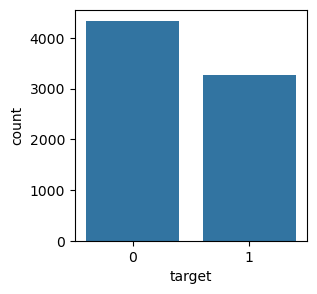

In [4]:
print(train.target.value_counts())
print(f'Percentage of target=1: {train.target.value_counts()[1]/len(train)*100:.2f}%')

# plot the target distribution
plt.figure(figsize=(3,3))
sns.countplot(x='target', data=train)


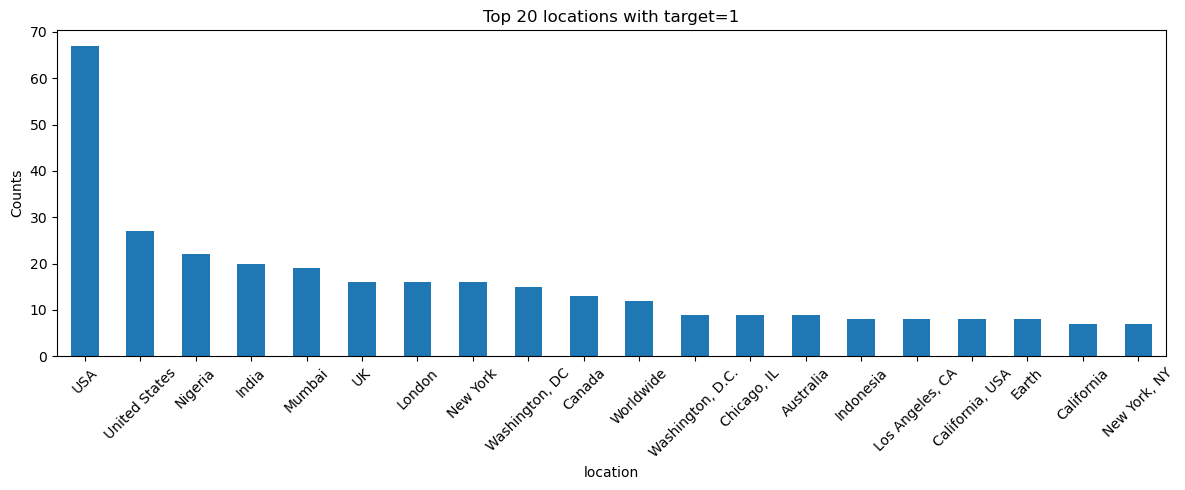

In [12]:
# the top 20 keywords with target=1
top20_loc = train[train['target']==1].location.value_counts().nlargest(20)

top20_loc.plot(kind='bar', figsize=(12,5)) # ,fontsize=12, color='lightblue'
plt.title('Top 20 locations with target=1')
plt.ylabel('Counts')
plt.tick_params(axis='x', rotation=45)
plt.tight_layout()

In [13]:
# display keyword sameples
train.keyword.sample(5)

5519    quarantined
6806        tragedy
4237      hazardous
5274    oil%20spill
1807          crash
Name: keyword, dtype: object

In [59]:
# split the keywords by '%20' and stack them into rows
# retain the target value for each word
# concatenate the two dataframes with target=0 and target=1

def split_keywords_by_target(df, target_value):
    
    filtered_df = df[df['target'] == target_value]
    words = (filtered_df['keyword'].str.replace('%20', ' ')
            .str.split(expand=True).stack().reset_index(level=1, drop=True)
            .to_frame('word'))
    words['target'] = target_value
    
    return words

words_0 = split_keywords_by_target(train, 0)
words_1 = split_keywords_by_target(train, 1)

combined_words = pd.concat([words_0, words_1])


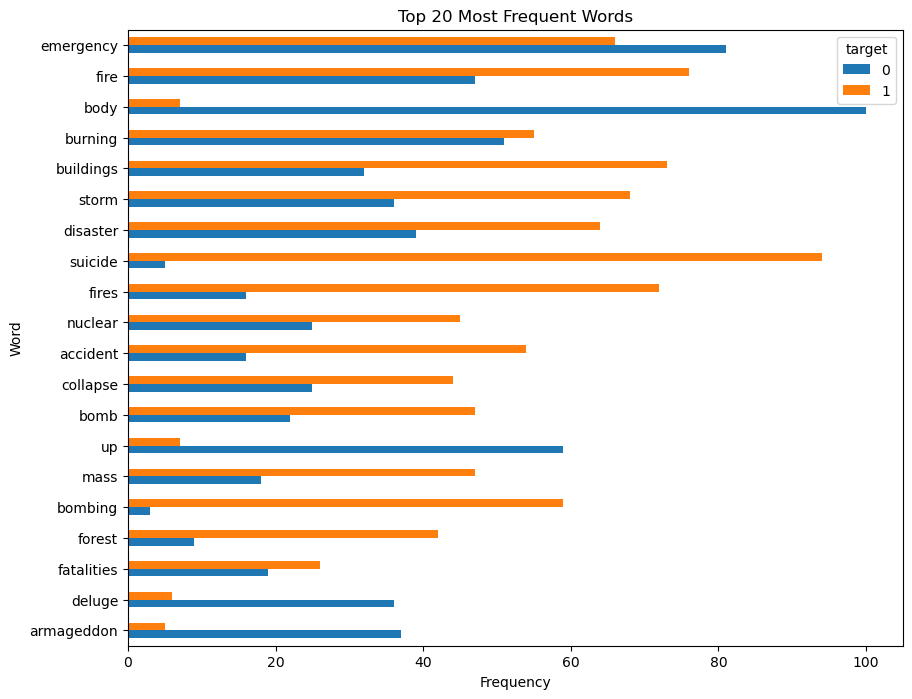

In [60]:
# plot the top 20 most frequent keywords (sum of target=0 and target=1)

top_words = combined_words['word'].value_counts().nlargest(20).index
top_words_target = combined_words[combined_words['word'].isin(top_words)]
top_words_counts = top_words_target.groupby(['word', 'target']).size().unstack(fill_value=0)
top_words_sorted = top_words_counts.reindex(top_words)
top_words_sorted = top_words_sorted.iloc[::-1]

top_words_sorted.plot(kind='barh', stacked=False, figsize=(10, 8))
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()


The plot displays the top 20 most frequent words in both disaster and non-disaster texts. It is noticeable that certain words appear much more frequently in non-disaster texts than in disaster texts, such as 'body', 'up', 'deluge', and 'armageddon'.

Conversely, there are words that appear much more frequently in disaster texts than in non-disaster texts, including 'suicide', 'fire/fires', 'accident', 'bombing', and 'forest'.

Words such as 'emergency', 'burning', and 'fatalities' commonly occur in both categories.

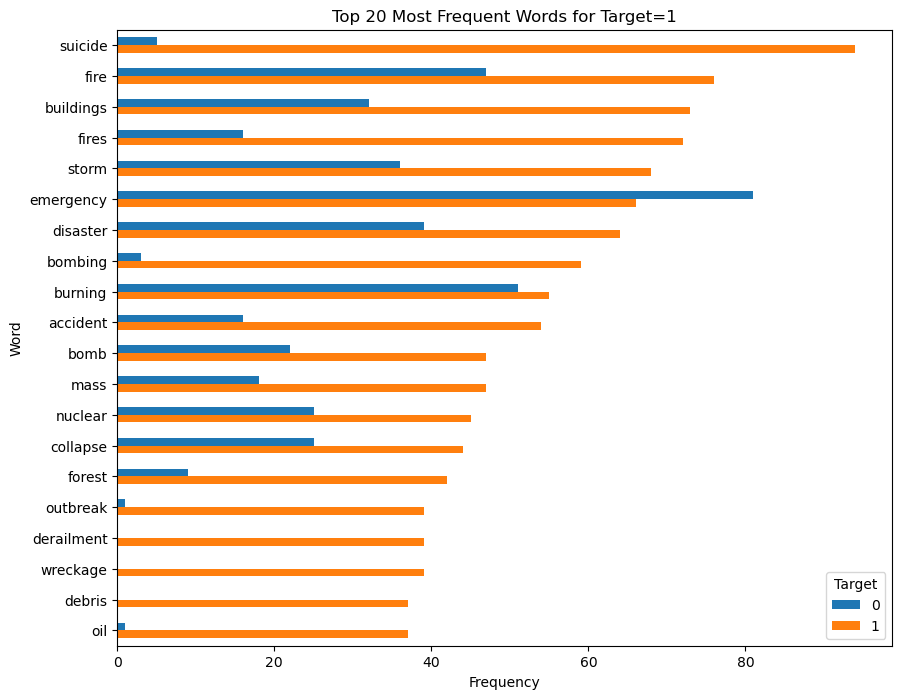

In [61]:
# plot the top 20 most frequent keywords for target=1

top_words_for_target_1 = combined_words[combined_words['target'] == 1]['word'].value_counts().nlargest(20)
filtered_data_for_top_words = combined_words[combined_words['word'].isin(top_words_for_target_1.index)]
grouped_counts = filtered_data_for_top_words.groupby(['word', 'target']).size().unstack(fill_value=0)
sorted_grouped_counts = grouped_counts.reindex(top_words_for_target_1.index)
sorted_grouped_counts.plot(kind='barh', stacked=False, figsize=(10, 8))
plt.title('Top 20 Most Frequent Words for Target=1')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.legend(title='Target')
plt.gca().invert_yaxis() 
plt.show()


The plot above is arranged based on the words that appear most frequently in disaster texts. It's noteworthy that words like 'suicide', 'fire/fires', 'storm', 'bombing', 'accident', 'derailment', 'wreckage', and 'debris' are all very important keywords.

In [62]:
# set stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# function to clean the text
def clean_text(text):

    text = text.replace('&amp;', ' ').replace('%20', ' ')
    pattern = re.compile(r'"([^"]*)"|([a-zA-Z0-9]+)')
    words = pattern.findall(text)
    words = word_tokenize(text.lower())
    cleaned_words = [lemmatizer.lemmatize(word) for word in words if word.isalpha() and word not in stop_words]
    
    return cleaned_words


In [63]:
# test 
# text = 'buildings%20on%20fire,"Mighty Tempe, Arizona",Failure doesnÛªt exist. It'
# cleaned_text = clean_text(text)
# print(cleaned_text)

# test
# text = '@Failure #black doesnÛªt exist. It, buildings%20on%20fire,"Mighty Tempe, Arizona"'
# cleaned_text = clean_text(text)
# print(cleaned_text)

In [64]:
# apply the clean_text function to the text column
train['cleaned_text'] = train['text'].apply(clean_text)


In [65]:
train.sample(1).cleaned_text.values

array([list(['warcraft', 'mode', 'likely', 'coming', 'hero', 'storm', 'http', 'http', 'http'])],
      dtype=object)

In [66]:
# 'word_count' calculated the number of words in the cleaned_text
train['word_count'] = train['cleaned_text'].apply(lambda x: len(str(x).split()))


Description of word counts for target=0:
count    4342.000000
mean        8.699217
std         3.609771
min         1.000000
25%         6.000000
50%         9.000000
75%        11.000000
max        23.000000
Name: word_count, dtype: float64

Description of word counts for target=1:
count    3271.000000
mean        9.735861
std         3.075293
min         1.000000
25%         8.000000
50%        10.000000
75%        12.000000
max        21.000000
Name: word_count, dtype: float64

Target=0 Skewness: 0.008641606416322537
Target=0 Kurtosis: -0.6317737043486775

Target=1 Skewness: -0.13758950497298403
Target=1 Kurtosis: -0.2744096286757687



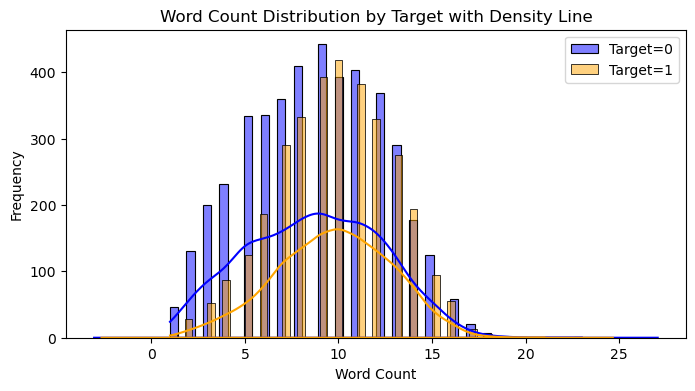

In [67]:
# describe the word count for target=0 and target=1
print("Description of word counts for target=0:")
print(train[train['target'] == 0]['word_count'].describe())
print("\nDescription of word counts for target=1:")
print(train[train['target'] == 1]['word_count'].describe())
print('')

# calculate the skewness and kurtosis of the word count for target=0 and target=1
for target in [0, 1]:
    subset = train[train['target'] == target]
    skewness = subset['word_count'].skew()
    kurtosis = subset['word_count'].kurtosis()
    print(f"Target={target} Skewness: {skewness}")
    print(f"Target={target} Kurtosis: {kurtosis}\n")


# plot the word count distribution and density line
fig, ax = plt.subplots(figsize=(8,4))
colors = {0: 'blue', 1: 'orange'}

for target in [0, 1]: 
    subset = train[train['target'] == target]
    sns.histplot(subset['word_count'], bins=50, kde=True, color=colors[target], alpha=0.5, label=f'Target={target}', ax=ax)
    sns.kdeplot(subset['word_count'], color=colors[target], ax=ax, bw_adjust=2) # bw_adjust=2 to smooth the density line
ax.set_title('Word Count Distribution by Target with Density Line')
ax.set_xlabel('Word Count')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()

From the above information, we know that the non-disaster tweets have a skewness close to 0, indicating that their word count distribution is close to symmetrical. The disaster tweets have a slightly negative skewness, suggesting a slight leftward skew in the word count distribution, meaning there are more tweets with a higher word count.

Disaster tweets are slightly longer than non-disaster tweets, with less variability in word count.

In [68]:
# function to process the data
def process_data(df):

    df.keyword.fillna('', inplace=True)
    df.location.fillna('', inplace=True) 
    df['all_text'] = df['text'] + ' ' +  df['keyword'] + ' ' + df['location']
    df['cleaned_all_text'] = df['all_text'].apply(clean_text)
    df['cleaned_all_str'] = df['cleaned_all_text'].apply(lambda x: ' '.join(x))
    
    return df


In [69]:
# apply the process_data function to the train data
train = process_data(train)

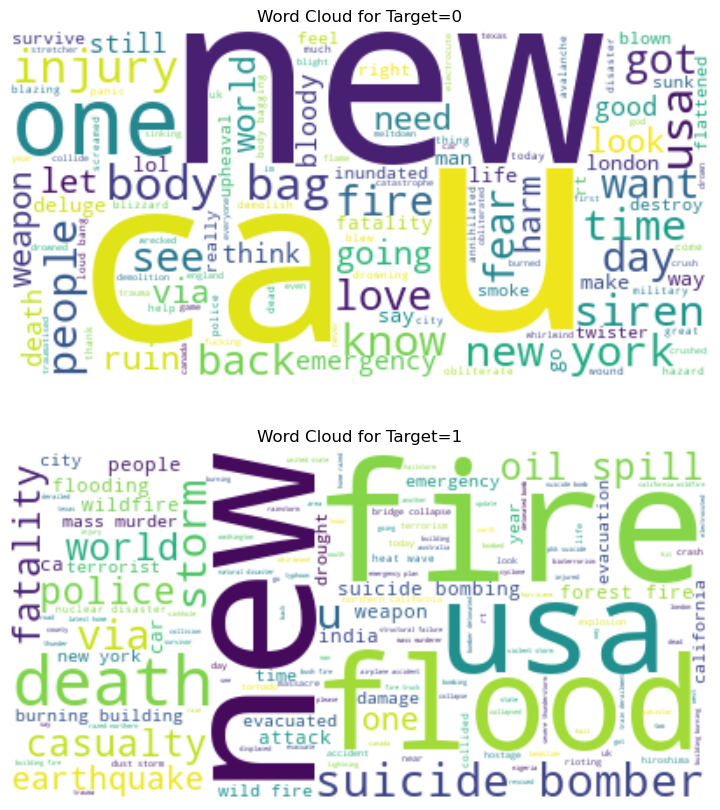

In [70]:
# transform the target column to a string type
text_0 = ' '.join([' '.join(text) for text in train[train['target'] == 0]['cleaned_all_text'] if isinstance(text, list)])
text_1 = ' '.join([' '.join(text) for text in train[train['target'] == 1]['cleaned_all_text'] if isinstance(text, list)])

# create word clouds
wordcloud_0 = WordCloud(background_color='white').generate(text_0)
wordcloud_1 = WordCloud(background_color='white').generate(text_1)

# plot the word clouds
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

ax[0].imshow(wordcloud_0, interpolation='bilinear')
ax[0].axis('off')
ax[0].set_title('Word Cloud for Target=0')

ax[1].imshow(wordcloud_1, interpolation='bilinear')
ax[1].axis('off')
ax[1].set_title('Word Cloud for Target=1')

plt.show()


Here are two word clouds, each corresponding to target=0 and target=1. The size of the words in the clouds reflects their frequency in the respective dataset. 

In the word cloud for target=0, we see larger words such as 'love', 'day', 'time', 'fear', and 'people'... This might indicate that non-disaster tweets tend to discuss everyday life, emotional expressions, or general topics.

Conversely, the word cloud for target=1 contains terms like 'flood', 'fire', 'death', 'suicide', 'bomber', 'storm' and 'oil spill', 'cacsualty'... This shows that disaster tweets are likely more focused on topics related to disasters, accidents, and emergencies.

## Models

### GRU

**Gated Recurrent Unit (GRU)** is a type of recurrent neural network (RNN) architecture. It manages the flow of information by incorporating update gates and reset gates, thus effectively capturing long-term dependencies, aimed at solving the problem of long-term dependencies in standard RNNs.

In [71]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['cleaned_all_str'])
sequences = tokenizer.texts_to_sequences(train['cleaned_all_str'])
data = pad_sequences(sequences, maxlen=100)

X_train, X_test, y_train, y_test = train_test_split(data, train['target'], test_size=0.2)

model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=100),
    Dropout(0.2), 
    GRU(128, return_sequences=True),
    Dropout(0.2), 
    GRU(128, return_sequences=True),
    Dropout(0.2),
    GRU(128, return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])


lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=10000,
    decay_rate=0.9)

optimizer=optimizers.legacy.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=4,         
    verbose=1,           
    restore_best_weights=True 
)

history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/50
191/191 [==============================] - 31s 149ms/step - loss: 0.6909 - accuracy: 0.5594 - val_loss: 0.6885 - val_accuracy: 0.5647
Epoch 2/50
191/191 [==============================] - 28s 145ms/step - loss: 0.6845 - accuracy: 0.5718 - val_loss: 0.6807 - val_accuracy: 0.5647
Epoch 3/50
191/191 [==============================] - 28s 145ms/step - loss: 0.6733 - accuracy: 0.5718 - val_loss: 0.6702 - val_accuracy: 0.5647
Epoch 4/50
191/191 [==============================] - 28s 145ms/step - loss: 0.6608 - accuracy: 0.5724 - val_loss: 0.6605 - val_accuracy: 0.5680
Epoch 5/50
191/191 [==============================] - 27s 143ms/step - loss: 0.6470 - accuracy: 0.6003 - val_loss: 0.6477 - val_accuracy: 0.6080
Epoch 6/50
191/191 [==============================] - 27s 144ms/step - loss: 0.6253 - accuracy: 0.6731 - val_loss: 0.6296 - val_accuracy: 0.6717
Epoch 7/50
191/191 [==============================] - 27s 144ms/step - loss: 0.5994 - accuracy: 0.7240 - val_loss: 0.6081 - val_ac

In [72]:
# func to plot the training and validation loss and accuracy
def score_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    auc = history.history['accuracy']
    val_auc = history.history['val_accuracy']
    epochs = range(1, len(loss) + 1)
    
    plt.figure(figsize=(12, 5)) 
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, auc, label='Training Accuracy')
    plt.plot(epochs, val_auc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()  
    plt.show()


In [73]:
# func to plot confusion matrix heatmap
def cm_heatmap(target, pred):
    
    print(f'Confusion Matrix:\n{confusion_matrix(target, pred)}')
    cm = confusion_matrix(target, pred, normalize='true')
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt=".3f", cmap='Blues')
    #plt.title('Confusion Matrix')
    plt.ylabel('Actual labels')
    plt.xlabel('Predicted labels')
    plt.show()    


In [84]:
# func to plot ROC curve
def roc_curve_plot(y_true, y_pred):
    roc_auc = roc_auc_score(y_true, y_pred)
    #print(f'ROC AUC Score: {roc_auc:.3f}')
    
    fpr, tpr, thr = roc_curve(y_true, y_pred)
    plt.figure(figsize=(5, 3))
    plt.plot(fpr, tpr, label='auc_roc= %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thr[optimal_idx]
    print(f'Optimal Threshold: {optimal_threshold:.3f}')

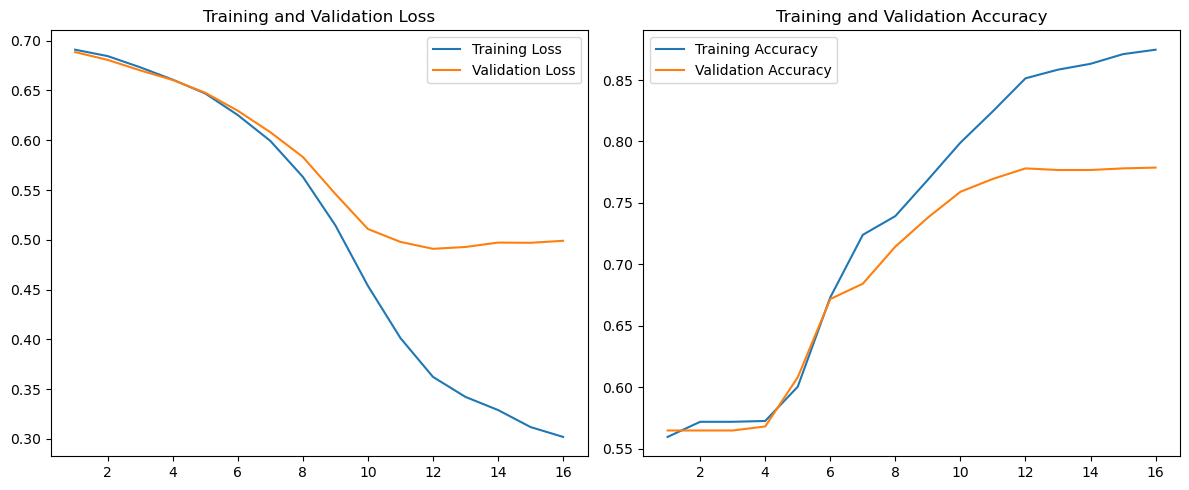

In [75]:
score_history(history) 

From the loss curves, we can observe that both training and validation losses decrease with the increase in epochs, indicating that the model is gradually improving its prediction ability. However, aftr around 10 epochs, the validation loss stops dcreasing and even slightly incrases, which might indicate overfitting. The model is performing better on the training data ut not improving or even worsening on unseen data.

The accuracy curves show that both training and validation accuracies are increasing with epochs. However, similar to the loss curves, the validation accuracy seems to plateau after about 10 epochs, which might also be an indicator of overfitting.

In [85]:
train_pred = model.predict(X_train)
val_pred = model.predict(X_test)


48/48 [==============================] - 2s 34ms/step


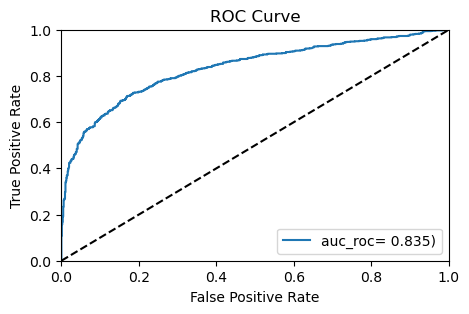

Optimal Threshold: 0.462


In [86]:
auc_roc = roc_curve_plot(y_test, val_pred)


In [87]:
threshold = 0.462

train_pred_class = (train_pred > threshold).astype(int)
val_pred_class = (val_pred > threshold).astype(int)

Confusion Matrix:
[[3109  373]
 [ 487 2121]]


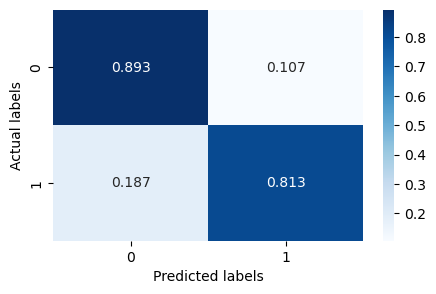

Confusion Matrix:
[[713 147]
 [190 473]]


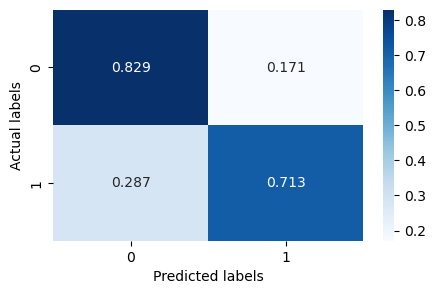

In [88]:
cm_heatmap(y_train, train_pred_class)
cm_heatmap(y_test, val_pred_class)


From the two cm heatmaps of training and validation data above, it can be seen that the model has weeker cability in distinguishing disaster tweets, with an overall decline in performance on unseen data.

It may be beneficail to attempt fine-tuning the data processing methods, adjusting the model architecture, and implementing regularization to improve the model's performance.

In [91]:
# test data processing
test = process_data(test)
test_sequences = tokenizer.texts_to_sequences(test['cleaned_all_str'])
test_data = pad_sequences(test_sequences, maxlen=100)

# predict the test data
test['target'] = (model.predict(test_data) > threshold).astype(int)

# save the prediction to a csv file
test[['id', 'target']].to_csv('pred/gru_f.csv', index=False)

102/102 [==============================] - 3s 33ms/step


The GRU model obtained the test public score:

<img src='pics/score_gru_f.png' width=500>

### BERT

**Bidirectional Encoder Representations from Transformers (BERT)** is a pre-trained model for natural language processing based on the Transformer architecture. It primarily consists of multiple layers of Transformer encoders. The Transformer utilizes an attention mechanism that enables the model to focus more on other relevant words when processing a specific word. This allows BERT to effectively capture long-distance dependencies in language.

In [128]:
batch_size = 32 
device = torch.device("cpu")

train_texts, val_texts, train_labels, val_labels = train_test_split(train['cleaned_all_str'], train['target'], test_size=.2)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=128)

train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']), torch.tensor(train_encodings['attention_mask']), torch.tensor(train_labels.tolist()))
val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']), torch.tensor(val_encodings['attention_mask']), torch.tensor(val_labels.tolist()))

train_loader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
validation_loader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)



In [109]:
patience = 4
epochs = 50
total_steps = len(train_loader) * epochs
best_val_loss = float('inf')
no_improvement_count = 0

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, eps=5e-8, weight_decay=0.05)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=total_steps)

def train(model, train_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    predictions, true_probs, true_labels = [], [], []

    for batch in train_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

        logits = outputs[1]
        probs = torch.sigmoid(logits)[:, 1].detach().cpu().numpy() 
        preds = np.round(probs).astype(int) 
        true_probs.append(probs)
        predictions.append(preds)
        true_labels.append(inputs['labels'].detach().cpu().numpy())

    predictions = np.concatenate(predictions, axis=0)
    true_probs = np.concatenate(true_probs, axis=0)  
    true_labels = np.concatenate(true_labels, axis=0)
    avg_train_loss = total_loss / len(validation_loader)
    train_acc = accuracy_score(true_labels, predictions)

    return avg_train_loss, train_acc, true_probs

def validate(model, validation_loader, device):
    model.eval()
    total_loss = 0
    predictions, true_probs, true_labels = [], [], []
    with torch.no_grad():
        for batch in validation_loader:
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1],
                      'labels': batch[2]}
            outputs = model(**inputs)
            loss = outputs[0]
            total_loss += loss.item()
            logits = outputs[1]
            probs = torch.sigmoid(logits)[:, 1].detach().cpu().numpy() 
            preds = np.round(probs).astype(int)  
            true_probs.append(probs)
            predictions.append(preds)
            true_labels.append(inputs['labels'].detach().cpu().numpy())

    predictions = np.concatenate(predictions, axis=0)
    true_probs = np.concatenate(true_probs, axis=0) 
    true_labels = np.concatenate(true_labels, axis=0)
    avg_val_loss = total_loss / len(validation_loader)
    val_acc = accuracy_score(true_labels, predictions)

    return avg_val_loss, val_acc, true_probs 

train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_model_state = None

schedule = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

for epoch_i in range(0, epochs):
    print(f'\nEpoch {epoch_i + 1}')
    avg_train_loss, train_acc, train_probs = train(model, train_loader, optimizer, schedule, device)
    train_losses.append(avg_train_loss)
    train_accs.append(train_acc)
    print(f'Training loss: {avg_train_loss}')
    print(f'Training Acc: {train_acc}')

    avg_val_loss, val_acc, val_probs = validate(model, validation_loader, device)
    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)
    print(f'Validation loss: {avg_val_loss}')
    print(f'Validation Acc Score: {val_acc}')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print("Stopping early due to no improvement.")
        break


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1
Training loss: 1.8516717382396262
Training Acc: 0.7865353037766831
Validation loss: 0.4319592989049852
Validation Acc Score: 0.8181221273801708

Epoch 2
Training loss: 1.430945625839134
Training Acc: 0.8502463054187193
Validation loss: 0.4258687895877908
Validation Acc Score: 0.8279711096520026

Epoch 3
Training loss: 1.0953939999841775
Training Acc: 0.8960591133004926
Validation loss: 0.5561926411852861
Validation Acc Score: 0.7997373604727511

Epoch 4
Training loss: 0.7478382013311299
Training Acc: 0.9308702791461412
Validation loss: 0.5623474523890764
Validation Acc Score: 0.8161523309258043

Epoch 5
Training loss: 0.5463002774340566
Training Acc: 0.9476190476190476
Validation loss: 0.6022706603786597
Validation Acc Score: 0.7859487852921865

Epoch 6
Training loss: 0.3872955850189707
Training Acc: 0.9628899835796387
Validation loss: 0.87387382350668
Validation Acc Score: 0.8030203545633617
Stopping early due to no improvement.


In [111]:
def score_plot(train_losses, val_losses, train_accs, val_accs):

    plt.figure(figsize=(12, 5)) 
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()  
    plt.show()


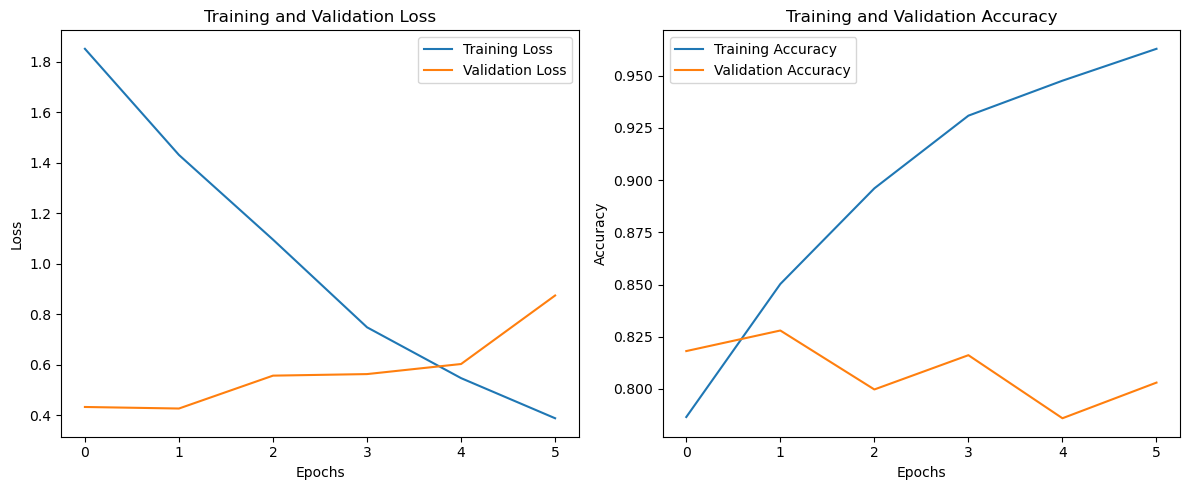

In [112]:
score_plot(train_losses, val_losses, train_accs, val_accs)

overfitting

In [113]:
# predict validation data

model.load_state_dict(best_model_state)
model.eval()
val_probs = [] 

with torch.no_grad():
    for batch in validation_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1]}
        outputs = model(**inputs)
        logits = outputs[0]
        probs = torch.sigmoid(logits)[:, 1].detach().cpu().numpy() 
        val_probs.extend(probs)

val_labels_array = np.array(val_labels)
val_probs_array = np.array(val_probs)


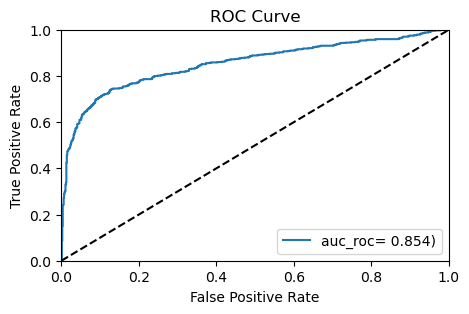

Optimal Threshold: 0.584


In [115]:
roc_curve_plot(val_labels_array, val_probs_array)

Confusion Matrix:
[[2904  578]
 [ 334 2274]]


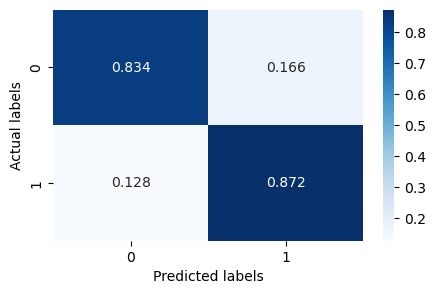

Confusion Matrix:
[[687 172]
 [150 514]]


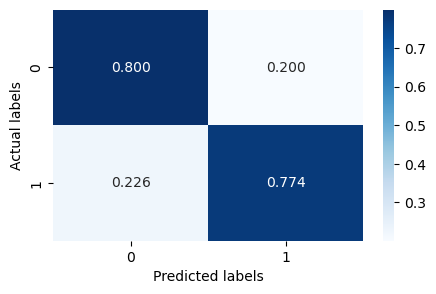

In [116]:
threshold = 0.353

train_pred_class = (train_pred > threshold).astype(int)
val_pred_class = (val_probs_array > threshold).astype(int)

cm_heatmap(y_train, train_pred_class)
cm_heatmap(val_labels_array, val_pred_class)

In [117]:
test = process_data(test)

test_encodings = tokenizer(test['cleaned_all_str'].tolist(), truncation=True, padding=True, max_length=128)
test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']), torch.tensor(test_encodings['attention_mask']))
test_loader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

model.eval()
test_probs = []

with torch.no_grad():
    for batch in test_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1]}
        outputs = model(**inputs)
        logits = outputs[0]
        probs = torch.sigmoid(logits)[:, 1].detach().cpu().numpy() 
        test_probs.extend(probs)

test['target'] = (np.array(test_probs) > threshold).astype(int)
test[['id', 'target']].to_csv('pred/bert_f.csv', index=False)



The BERT model obtained the test public score:

<img src='pics/score_bert_f.png' width=500>

## Hyperparameter Tuning

Here Optuna is utilized to minimize the average loss on the validation set by adjusting hyperparameters such as the learning rate, epsilon value, weight decay, and number of warmup steps.

In [118]:
def objective(trial):
    
    learning_rate = trial.suggest_loguniform('lr', 1e-7, 1e-4)
    eps = trial.suggest_loguniform('eps', 1e-9, 1e-6)
    weight_decay = trial.suggest_float('weight_decay', 0, 0.1)
    num_warmup_steps = trial.suggest_int('num_warmup_steps', 0, 1000)
    
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=learning_rate, eps=eps, weight_decay=weight_decay)
    
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps)
    
    avg_train_loss, train_acc, train_probs = train(model, train_loader, optimizer, scheduler, device)
    avg_val_loss, val_acc, val_probs = validate(model, validation_loader, device)
    
    return avg_val_loss


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2024-03-16 19:01:28,009] A new study created in memory with name: no-name-127d6c76-0422-408f-b189-4680d99f8590


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2024-03-16 19:06:49,670] Trial 0 finished with value: 0.6756349420174956 and parameters: {'lr': 4.714918284055208e-07, 'eps': 9.399521021429054e-07, 'weight_decay': 0.07941632908301867, 'num_warmup_steps': 814}. Best is trial 0 with value: 0.6756349420174956.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2024-03-16 19:12:00,712] Trial 1 finished with value: 0.4761150690416495 and parameters: {'lr': 2.215790953637548e-05, 'eps': 5.738144424534244e-07,

Best trial:
  Value: 0.4373560417443514
  Params: 
    lr: 8.382163313322564e-06
    eps: 1.5070540872414328e-09
    weight_decay: 0.06623352253194419
    num_warmup_steps: 184


In [120]:
# params = {'lr': 8.382163313322564e-06, 'eps': 1.5070540872414328e-09, 'weight_decay': 0.06623352253194419, 'num_warmup_steps': 184} 
params = study.best_params

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

optimizer = AdamW(model.parameters(), lr=params['lr'], eps=params['eps'], weight_decay=params['weight_decay'])
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=params['num_warmup_steps'], num_training_steps=total_steps)

train_losses = []
val_losses = []
train_accs = []
val_accs = []
best_model_state = None
best_val_loss = float('inf')
no_improvement_count = 0
patience = 5

for epoch_i in range(0, epochs):
    print(f'\nEpoch {epoch_i + 1}')
    avg_train_loss, train_acc, train_probs = train(model, train_loader, optimizer, scheduler, device)
    train_losses.append(avg_train_loss)
    train_accs.append(train_acc)
    print(f'Training loss: {avg_train_loss}')
    print(f'Training Acc: {train_acc}')

    avg_val_loss, val_acc, val_probs = validate(model, validation_loader, device)
    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)
    print(f'Validation loss: {avg_val_loss}')
    print(f'Validation Acc: {val_acc}')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print("Stopping early due to no improvement.")
        break

model.save_pretrained('models/bert_f_tuned')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1
Training loss: 2.110976219487687
Training Acc: 0.7425287356321839
Validation loss: 0.435242743541797
Validation Acc: 0.8036769533814839

Epoch 2
Training loss: 1.562836996357267
Training Acc: 0.8331691297208539
Validation loss: 0.42873857139299315
Validation Acc: 0.8161523309258043

Epoch 3
Training loss: 1.299620729056187
Training Acc: 0.8702791461412152
Validation loss: 0.4454641523770988
Validation Acc: 0.8220617202889035

Epoch 4
Training loss: 1.0895122948180263
Training Acc: 0.8983579638752053
Validation loss: 0.5265911067835987
Validation Acc: 0.7918581746552856

Epoch 5
Training loss: 0.8818632803158835
Training Acc: 0.9200328407224959
Validation loss: 0.5436601806432009
Validation Acc: 0.8095863427445831

Epoch 6
Training loss: 0.712041851792795
Training Acc: 0.9351395730706076
Validation loss: 0.5667429107512968
Validation Acc: 0.7971109652002626

Epoch 7
Training loss: 0.5929014877280375
Training Acc: 0.948111658456486
Validation loss: 0.6679910753349153
Validation 

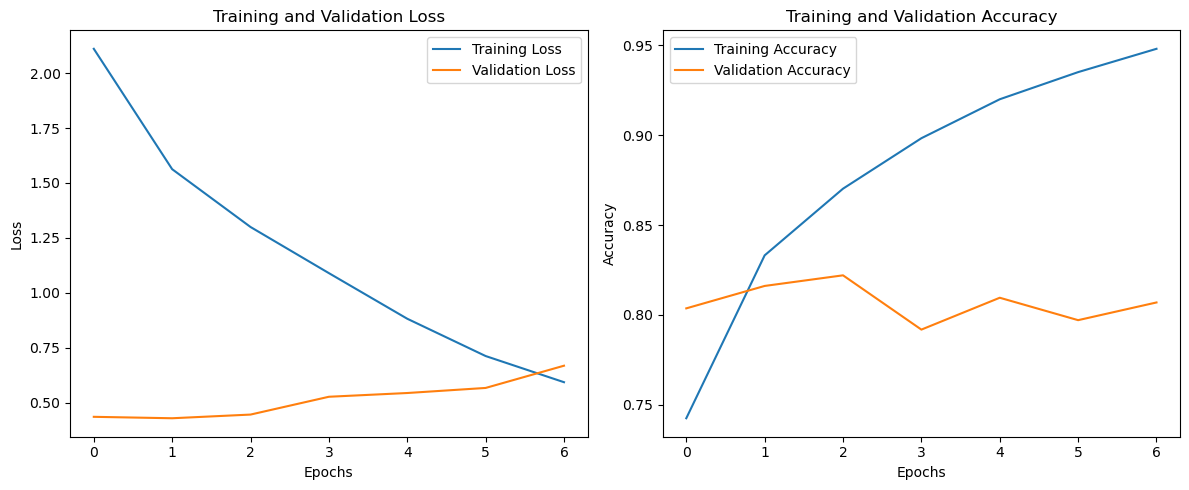

In [121]:
score_plot(train_losses, val_losses, train_accs, val_accs)

overfitting

In [122]:
model.load_state_dict(best_model_state)
model.eval()
val_probs = [] 

with torch.no_grad():
    for batch in validation_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1]}
        outputs = model(**inputs)
        logits = outputs[0]
        probs = torch.sigmoid(logits)[:, 1].detach().cpu().numpy() 
        val_probs.extend(probs)

val_labels_array = np.array(val_labels)
val_probs_array = np.array(val_probs)  


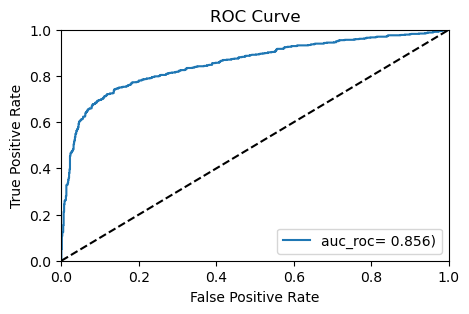

Optimal Threshold: 0.528


In [123]:
roc_curve_plot(val_labels_array, val_probs_array)

Confusion Matrix:
[[3198  284]
 [ 574 2034]]


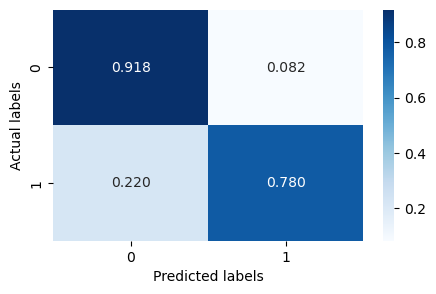

Confusion Matrix:
[[741 118]
 [171 493]]


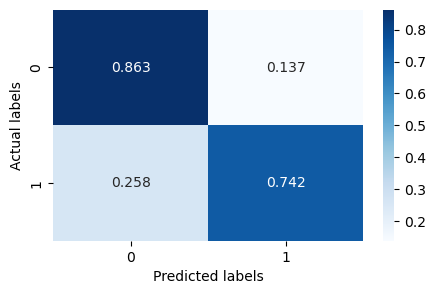

In [125]:
threshold = 0.528

train_pred_class = (train_pred > threshold).astype(int)
val_pred_class = (val_probs_array > threshold).astype(int)

cm_heatmap(y_train, train_pred_class)
cm_heatmap(val_labels_array, val_pred_class)

The performance of classifying 0 and 1 is better than that of the model using GRU.

In [126]:
test = process_data(test)

test_encodings = tokenizer(test['cleaned_all_str'].tolist(), truncation=True, padding=True, max_length=128)
test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']), torch.tensor(test_encodings['attention_mask']))
test_loader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

model.eval()
test_probs = []

with torch.no_grad():
    for batch in test_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1]}
        outputs = model(**inputs)
        logits = outputs[0]
        probs = torch.sigmoid(logits)[:, 1].detach().cpu().numpy() 
        test_probs.extend(probs)

test['target'] = (np.array(test_probs) > threshold).astype(int)
test[['id', 'target']].to_csv('pred/bert_f_tuned.csv', index=False)



The GRU model obtained the test public score:

<img src='pics/score_bert_f_tuned.png' width=500>

## Summary

| Model | Public Score |
| --- | --- |
| GRU | 0.77750 |
| BERT | 0.79558 |
| BERT_Tuned | 0.81489 |

<br>

- GRU is designed for sequential data processing. It outperforms traditional RNNs by efficiently capturing long-term dependencies. However, its ability to handle subtle semantic differences in text may be limited.

- BERT is a Transformer-based model designed to understand and capture semantic relationships and contextual information in text.

- BERT_Tuned model enhanced performance by optimizing hyperparameters, achieved a public score of 0.81489.

<br>

### Directions for Improvement

- Expand the training dataset by introducing more diverse types of disasters and language usage to improve the model's generalization ability.

- Improve text cleaning and preprocessing steps, such as better tokenization, removing irrelevant characters, synonym replacement, etc.

- Conduct detailed hyperparameter tuning, such as adjusting the learning rate, batch size, number of hidden units, etc., to find the optimal model configuration.

- Try combining the strengths of different models to achieve better performance.

- Explore the latest NLP models and techniques to see if they offer superior performance on this task.